In [2]:
import os
import sys

#Import config file. Update config.py according to your environment
import config

import pandas as pd
import numpy as np

import tensorflow as tf

from Rakuten_preprocessing import Rakuten_img_path

from src.text.classifiers import MLClassifier

from src.utils.batch import fit_save_all
from src.utils.load import load_classifier

import ast

2024-03-12 16:02:19.813903: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-12 16:02:19.866391: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-12 16:02:19.866444: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-12 16:02:19.869051: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-12 16:02:19.882028: I tensorflow/core/platform/cpu_feature_guar

In [3]:
import os
import sys

#Import config file. Update config.py according to your environment
import config

import pandas as pd
import numpy as np

import tensorflow as tf

from Rakuten_preprocessing import Rakuten_img_path

from src.text.classifiers import TFbertClassifier
from src.image.classifiers import ImgClassifier
from src.multimodal.classifiers import TFmultiClassifier

from src.utils.batch import fit_save_all
from src.utils.plot import plot_training_history
from src.utils.load import load_batch_results

import datetime


In [4]:
data_train = pd.read_csv(os.path.join(config.path_to_data, 'df_train_index.csv'))
data_train['testset'] = False
data_test = pd.read_csv(os.path.join(config.path_to_data, 'df_test_index.csv'))
data_test['testset'] = True
data = pd.concat([data_train, data_test], axis=0)

#merging text into token column
colnames = ['designation_translated', 'description_translated'] #['designation', 'description']#
data['tokens'] = data[colnames].apply(lambda row: ' '.join(s.lower() for s in row if isinstance(s, str)), axis=1)

#path to images into img_path column
data['img_path'] = Rakuten_img_path(img_folder=config.path_to_images,
                             imageid=data['imageid'], productid=data['productid'], suffix='_resized')


In [5]:
#labels of encoded classes
class_labels = data.groupby('prdtypedesignation')['prdtypeindex'].first().reset_index()
class_labels.index = class_labels['prdtypeindex']
class_labels = class_labels.drop(columns='prdtypeindex').sort_index()

## Creating train and test sets

In [6]:
Img_train = data.loc[~data['testset'], 'img_path']
Img_test = data.loc[data['testset'], 'img_path']

Txt_train = data.loc[~data['testset'], 'tokens']
Txt_test = data.loc[data['testset'], 'tokens']

y_train = data.loc[~data['testset'],'prdtypeindex']
y_test = data.loc[data['testset'],'prdtypeindex']

#To be fed into any of our sklearn classifiers, X_train and X_test
#should be dataframes with columns tokens and img_path
X_train = pd.DataFrame({'tokens': Txt_train, 'img_path': Img_train})
X_test = pd.DataFrame({'tokens': Txt_test, 'img_path': Img_test})

#All data for cross-validated scores
X = pd.concat([X_train, X_test], axis=0)
y = pd.concat([y_train, y_test], axis=0)

#Number of classes
num_classes = len(np.unique(data['prdtypeindex']))

In [11]:


# df_results = fix_results('results_benchmark_bert.csv', X_test, y_test)
from src.utils.load import load_batch_results
df_results = load_batch_results('results_benchmark_bert') 
display(df_results)

loading from Local


All model checkpoint layers were used when initializing TFCamembertModel.

All the layers of TFCamembertModel were initialized from the model checkpoint at /mnt/c/Users/Julien Fournier/Documents/DST/RakutenProject/models/base_models/camembert-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFCamembertModel for predictions without further training.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


loading weights from  text/camembert-base


2024-03-12 16:06:10.245074: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


531/531 [==============================] - 155s 277ms/step
loading from Local


All model checkpoint layers were used when initializing TFCamembertModel.

All the layers of TFCamembertModel were initialized from the model checkpoint at /mnt/c/Users/Julien Fournier/Documents/DST/RakutenProject/models/base_models/camembert-base-ccnet.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFCamembertModel for predictions without further training.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


loading weights from  text/camembert-base-ccnet
531/531 [==============================] - 149s 275ms/step
loading from Local


All model checkpoint layers were used when initializing TFFlaubertModel.

All the layers of TFFlaubertModel were initialized from the model checkpoint at /mnt/c/Users/Julien Fournier/Documents/DST/RakutenProject/models/base_models/flaubert_base_uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFFlaubertModel for predictions without further training.


loading weights from  text/flaubert_base_uncased
531/531 [==============================] - 145s 266ms/step


,modality,class,vectorization,classifier,tested_params,best_params,score_test,score_test_cat,conf_mat_test,score_train,fit_time,score_cv_test,score_cv_train,fit_cv_time,probs_test,pred_test,y_test,model_path
0,text,TFbertClassifier,NaN,camembert-base-ccnet,"{'max_length': [256], 'num_class': [27], 'drop...",NaN,0.885786,"[0.6857142857142857, 0.8447319778188539, 0.945...","[[420, 2, 5, 1, 6, 3, 0, 0, 0, 2, 0, 0, 0, 2, ...",None,16955.933911,NaN,NaN,NaN,"[[8.36602794151986e-06, 1.3363852303882595e-05...","[7, 10, 20, 2, 16, 0, 13, 20, 24, 23, 4, 15, 1...","[7, 10, 20, 2, 16, 0, 13, 20, 24, 23, 4, 15, 1...",text/camembert-base-ccnet
1,text,TFbertClassifier,NaN,camembert-base,"{'max_length': [256], 'num_class': [27], 'drop...",NaN,0.885566,"[0.6816, 0.8400735294117646, 0.956739811912225...","[[426, 0, 3, 1, 3, 2, 1, 0, 0, 3, 0, 0, 0, 1, ...",None,17225.562966,NaN,NaN,NaN,"[[2.161696829716675e-05, 4.221343624521978e-05...","[7, 10, 20, 2, 16, 0, 13, 20, 24, 23, 18, 15, ...","[7, 10, 20, 2, 16, 0, 13, 20, 24, 23, 4, 15, 1...",text/camembert-base
2,text,TFbertClassifier,NaN,flaubert_base_uncased,"{'max_length': [256], 'num_class': [27], 'drop...",NaN,0.877612,"[0.6490503715937243, 0.8396946564885497, 0.951...","[[393, 2, 5, 4, 2, 2, 1, 0, 0, 3, 0, 0, 0, 0, ...",None,15138.514543,NaN,NaN,NaN,"[[1.0911815895298105e-10, 2.0805575040583335e-...","[7, 11, 20, 2, 16, 22, 13, 20, 24, 23, 5, 15, ...","[7, 10, 20, 2, 16, 0, 13, 20, 24, 23, 4, 15, 1...",text/flaubert_base_uncased


In [25]:
# df_results = load_batch_results('results_benchmark_bert')
df_results = load_batch_results('results_benchmark_bert')
display(df_results)
   
# col_to_convert = ['conf_mat_test', 'probs_test', 'pred_test', 'y_test']
# for col in col_to_convert:
    # df_results['conf_mat_test'] #= df_results['conf_mat_test'][~df_results['conf_mat_test'].isna()].apply(ast.literal_eval).apply(np.array)

,modality,class,vectorization,classifier,tested_params,best_params,score_test,score_test_cat,conf_mat_test,score_train,fit_time,score_cv_test,score_cv_train,fit_cv_time,probs_test,pred_test,y_test,model_path
0,text,TFbertClassifier,NaN,camembert-base-ccnet,"{'max_length': [256], 'num_class': [27], 'drop...",NaN,0.885786,"[0.6857142857142857, 0.8447319778188539, 0.945...","[[420, 2, 5, 1, 6, 3, 0, 0, 0, 2, 0, 0, 0, 2, ...",NaN,16955.933911,NaN,NaN,NaN,"[[8.36602794151986e-06, 1.3363852303882595e-05...","[7, 10, 20, 2, 16, 0, 13, 20, 24, 23, 4, 15, 1...","[7, 10, 20, 2, 16, 0, 13, 20, 24, 23, 4, 15, 1...",text/camembert-base-ccnet
1,text,TFbertClassifier,NaN,camembert-base,"{'max_length': [256], 'num_class': [27], 'drop...",NaN,0.885566,"[0.6816, 0.8400735294117646, 0.956739811912225...","[[426, 0, 3, 1, 3, 2, 1, 0, 0, 3, 0, 0, 0, 1, ...",NaN,17225.562966,NaN,NaN,NaN,"[[2.161696829716675e-05, 4.221343624521978e-05...","[7, 10, 20, 2, 16, 0, 13, 20, 24, 23, 18, 15, ...","[7, 10, 20, 2, 16, 0, 13, 20, 24, 23, 4, 15, 1...",text/camembert-base
2,text,TFbertClassifier,NaN,flaubert_base_uncased,"{'max_length': [256], 'num_class': [27], 'drop...",NaN,0.877612,"[0.6490503715937243, 0.8396946564885497, 0.951...","[[393, 2, 5, 4, 2, 2, 1, 0, 0, 3, 0, 0, 0, 0, ...",NaN,15138.514543,NaN,NaN,NaN,"[[1.0911815895298105e-10, 2.0805575040583335e-...","[7, 11, 20, 2, 16, 22, 13, 20, 24, 23, 5, 15, ...","[7, 10, 20, 2, 16, 0, 13, 20, 24, 23, 4, 15, 1...",text/flaubert_base_uncased


AttributeError: module 'matplotlib.cm' has no attribute 'warmcold'

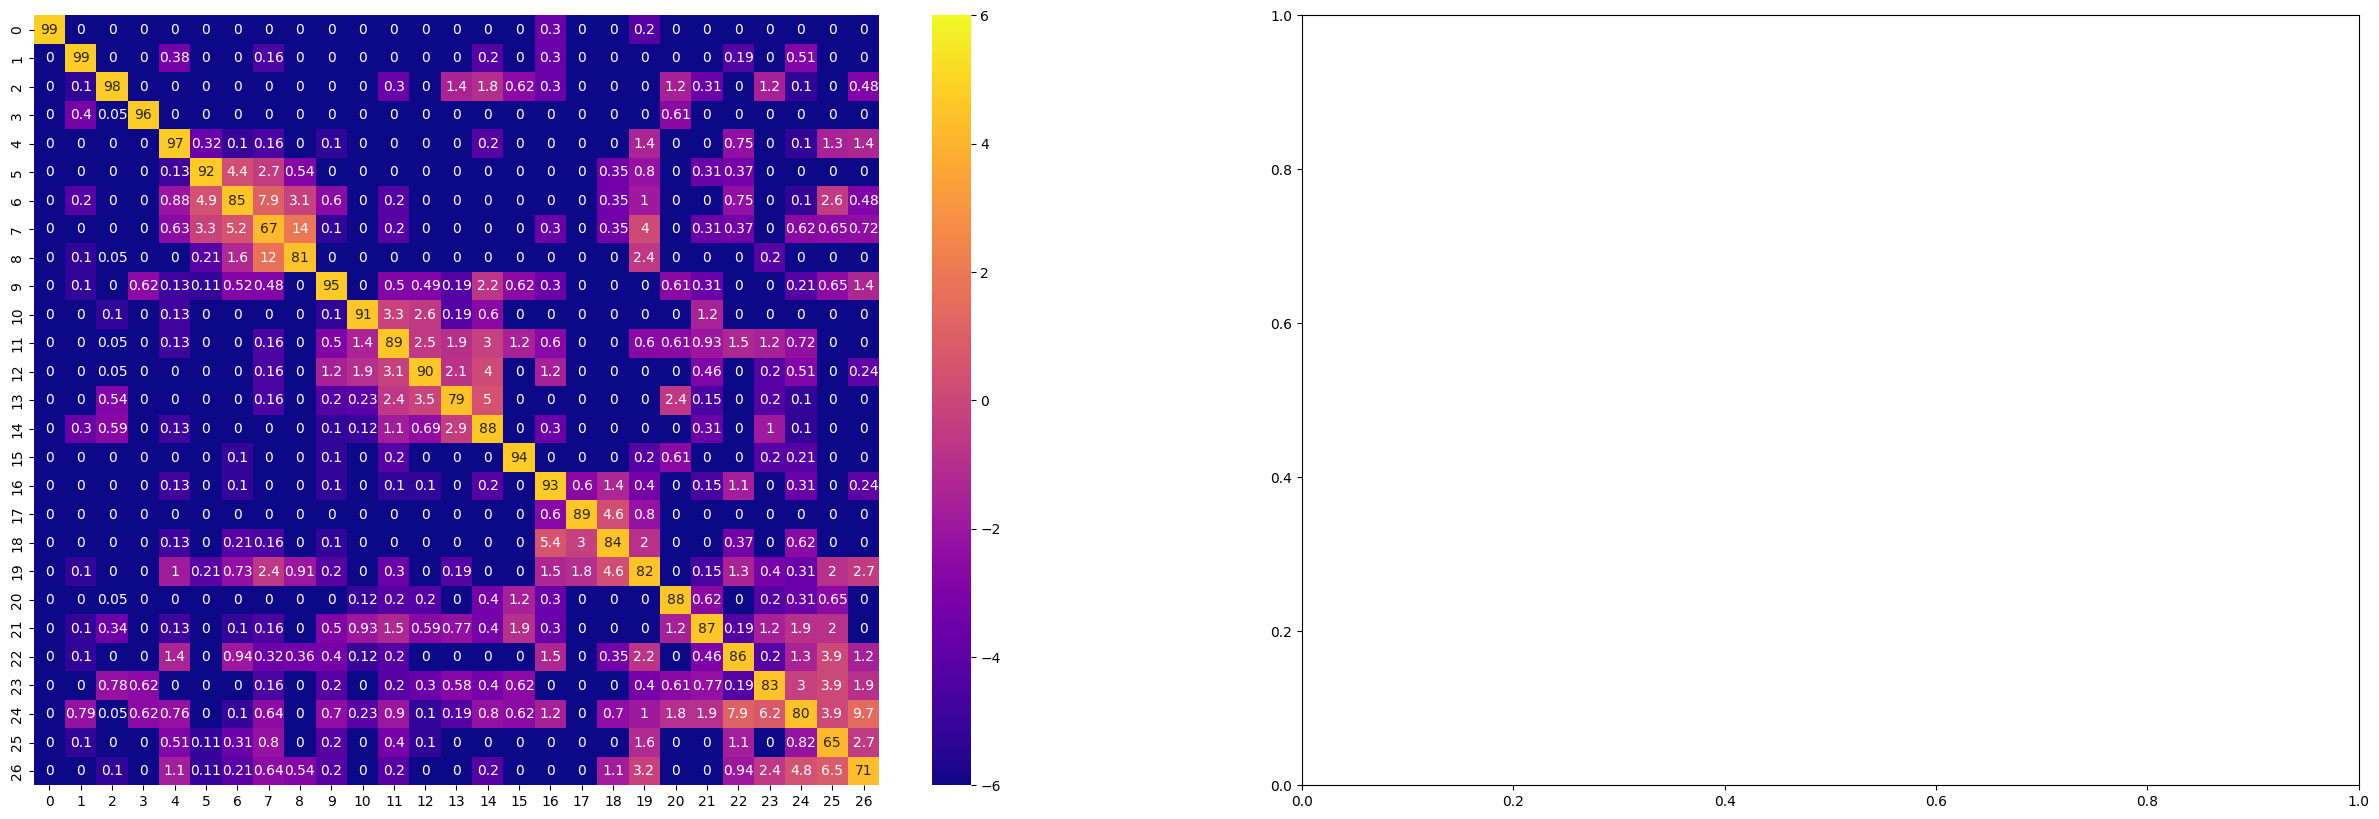

In [120]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.cluster.hierarchy import linkage, leaves_list

conf_mat = df_results.loc[0, 'conf_mat_test']
chance_level = conf_mat.sum(axis=1)
chance_level = chance_level / chance_level.sum()
conf_mat = (conf_mat / conf_mat.sum(axis=1))

Z = linkage(conf_mat, 'ward')
order = leaves_list(Z)
conf_mat = conf_mat[order, :]
conf_mat = conf_mat[:, order]

# conf_mat = conf_mat / chance_level
conf_mat_log = np.log(conf_mat / (1/27) + 1e-6)/np.log(2)

# np.fill_diagonal(conf_mat_log, (np.diag(conf_mat_log)-3)*3)

f, axs = plt.subplots(figsize=(30, 10), nrows=1, ncols=2)
sns.heatmap(conf_mat_log, vmin=-6, vmax=6, annot=np.round(conf_mat*100, 2), cmap=plt.cm.plasma, ax=axs[0])
# sns.heatmap(conf_mat_log, vmin=-8, vmax=8, annot=np.round(conf_mat_log, 2), cmap=plt.cm.bwr, ax=axs[1])
sns.heatmap(conf_mat_log, vmin=-8, vmax=8, annot=np.round(conf_mat_log, 2), cmap=plt.cm.warmcold, ax=axs[1])

<Axes: >

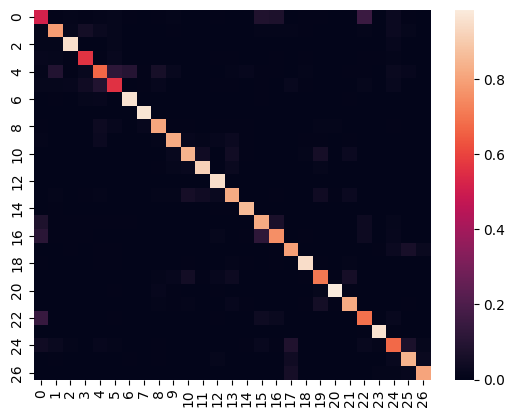

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(df_results.loc[0, 'conf_mat_test']/ df_results.loc[0, 'conf_mat_test'].sum(axis=1))

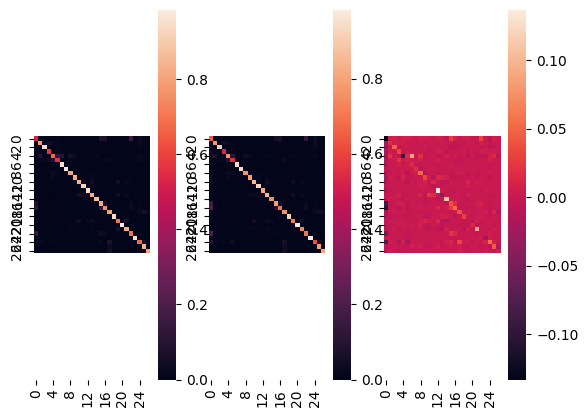

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.subplot(1, 3, 1)
sns.heatmap(clf1.confusion_mat / clf1.confusion_mat.sum(axis=1))
plt.axis('equal')
plt.subplot(1, 3, 2)
sns.heatmap(clf2.confusion_mat / clf1.confusion_mat.sum(axis=1))
plt.axis('equal')
plt.subplot(1, 3, 3)
sns.heatmap((clf1.confusion_mat - clf2.confusion_mat) / clf1.confusion_mat.sum(axis=1))
plt.axis('equal')

plt.show()